In [1]:
from pandas import read_csv
import numpy as np
from math import sin, cos, pi, atan2, asin, sqrt
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.fft import fft, fftfreq
from scipy.signal import filtfilt
import scipy

import Helper_Functions as hf

plt.style.use('seaborn-poster')

In [2]:
################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

################## DATA FRAME ##################
datafile = '../Data/Subscale2/VN/Subscale2_Truncated_014355.csv'
fields = ['Timestamp', 'Pres',
  'dTheta X', 'dTheta Y', 'dTheta Z',
  'Roll', 'Pitch', 'Yaw',
  'dVel X', 'dVel Y', 'dVel Z',
  'Qtn[0]', 'Qtn[1]', 'Qtn[2]', 'Qtn[3]',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Accel X', 'Accel Y', 'Accel Z'
  ]

df = read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]
numDataPoints = tdata.shape[0]

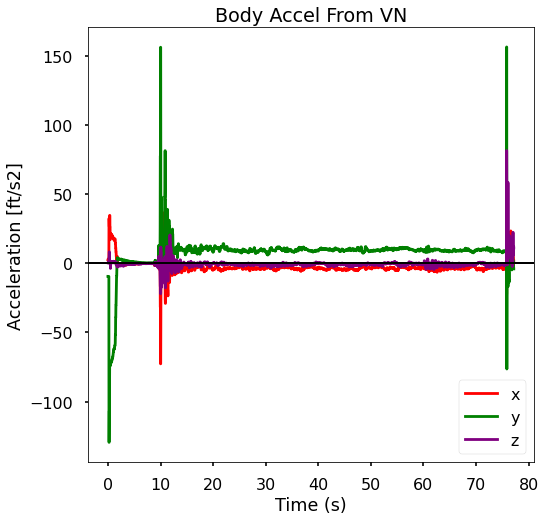

In [3]:
ax_vn = df['Accel X']# * ft
ay_vn = df['Accel Y']# * -ft
az_vn = df['Accel Z']# * ft

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ax_vn, color='red', label='x')
l3 = ax.plot(tdata, ay_vn, color='green', label='y')
l4 = ax.plot(tdata, az_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Body Accel From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [ft/s2]")
ax.legend()
plt.show()

## From Mechatronics Project: FFT

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


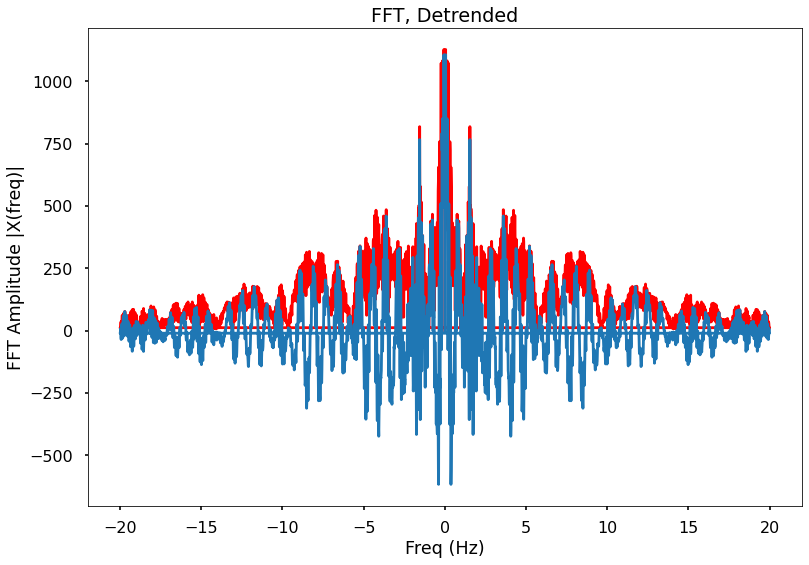

In [4]:
sr = 40  # Hz

# Turn dataset into a signal
x = az_vn
#DETREND: if we do not subtract the mean, then the a0 (DC value) of the FFT will be enormous
# and completely shadow the rest of the values.  Thus we must "detrend" AKA "mean substract"
xDetrended = [elem - sum(x)/len(x) for elem in x]
# sampling interval
ts = 1.0/sr
#t = range(numDataPoints)
t = tdata

## NUMPY ##
wD = np.fft.fft(xDetrended)
freqsD = np.fft.fftfreq(len(xDetrended),1/sr)
## SCIPY ##
Xscipy_YFD = fft(xDetrended)
Xscipy_XFD = fftfreq(len(Xscipy_YFD),1/sr)

# Only goes up to 20 Hz cause the sampling rate is 40 Hz? Fs=2Fmax
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.plot(freqsD, abs(wD), 'r', label="Numpy")
plt.plot(Xscipy_XFD,Xscipy_YFD, label="Scipy")
plt.title('FFT, Detrended')
plt.show()

In [5]:
def convert_freq_domain(tdata, accel_signal, fs=40):
    dt = 1/fs
    n = len(tdata)
    fhat = np.fft.fft(accel_signal,n)
    # Power Spectral Density
    PSD = fhat * np.conj(fhat) / n
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1,np.floor(n/2),dtype='int')
    
    return PSD, freq, L

In [6]:
def plot_freq_dom(tdata, accel_signal, w_low=0, w_high=0, original=0, fs=40):
    PSD, freq, L = convert_freq_domain(tdata, accel_signal, fs)
    
    plt.plot(freq[L],PSD[L], color='g', label='Filtered')
    if w_low is not 0 and w_high is not 0:
        plt.axvline(x=w_low, linestyle="--", color="k", linewidth=0.5, label='Filter lower bound')
        plt.axvline(x=w_high, linestyle="--", color="k", linewidth=0.5, label='Filter upper bound')
    if original is not 0:
        PSD, freq, L = convert_freq_domain(tdata, original, fs)
        plt.plot(freq[L],PSD[L], linewidth=0.5, color='r', label='Original')
    plt.xlim(freq[L[0]],freq[L[-1]])
    plt.title("Frequency Domain Components")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.show()

In [7]:
def Burton_FFT(tdata, accel_signal, dt=1/40):
    # Compute the Fast Fourier Transform (FFT)

    n = len(tdata)
    fhat = np.fft.fft(accel_signal,n)
    # Power Spectral Density
    PSD = fhat * np.conj(fhat) / n
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1,np.floor(n/2),dtype='int')

    ## Uses the PSD to filter out noise

    # Use boolean masking
    max_threshold = 100
    indices = PSD > 100 # Find all freqs with large power
    PSDclean = PSD * indices  # Zero out all others
    fhat = indices * fhat  # Zero out small Fourier foeefs in Y
    ffilt = np.fft.ifft(fhat)  # Inverse FFT for filtered time signal
    
    return ffilt, fhat, PSDclean, PSD, freq, L

In [8]:
def Burton_Derived_FFT(tdata, accel_signal, dt=1/40):
    # Compute the Fast Fourier Transform (FFT)
    n = len(tdata)
    fhat = np.fft.fft(accel_signal,n)
    # Power Spectral Density
    PSD = fhat * np.conj(fhat) / n
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1,np.floor(n/2),dtype='int')

    ## Uses the PSD to filter out noise
    # Use boolean masking
    min_threshold, max_threshold = 1, 20
    PSD[0, min_threshold], PSD[max_threshold:-1] = 0, 0
    
    # Don't know how to map from the PSD to the fhat... what is fhat
    fhat = indices * fhat  # Zero out small Fourier foeefs in Y
    ffilt = np.fft.ifft(fhat)  # Inverse FFT for filtered time signal
    
    return None

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting compl

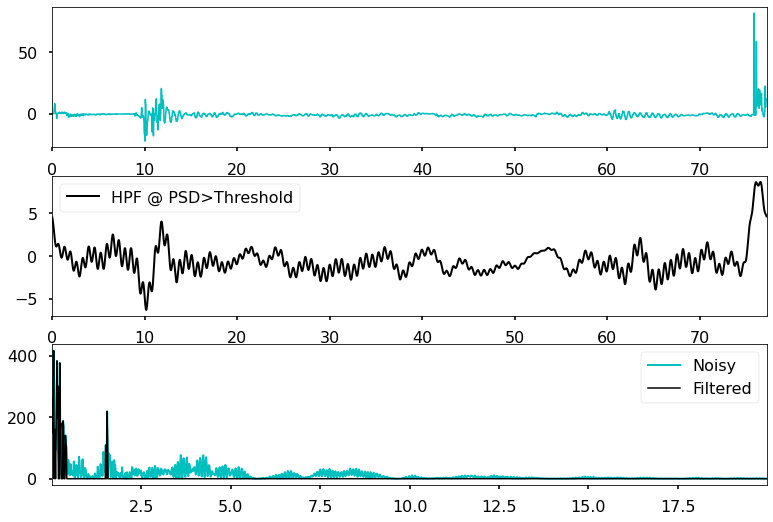

In [9]:
ffilt, fhat, PSDclean, PSD, freq, L = Burton_FFT(tdata, az_vn)

## Plots
fig,axs = plt.subplots(3,1)

plt.sca(axs[0])
plt.plot(t,az_vn,color='c',LineWidth=1.5,label='')
plt.xlim(t[0],t[-1])
#plt.legend()

plt.sca(axs[1])
plt.plot(t,ffilt,color='k',LineWidth=2,label=f'HPF @ PSD>Threshold')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSD[L],color='c',LineWidth=2,label='Noisy')
plt.plot(freq[L],PSDclean[L],color='k',LineWidth=1.5,label='Filtered')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.legend()

plt.show()

In [10]:
def bandPassFilter(signal, fs=40, low_freq=0.5, high_freq=15):
    nyq = 0.5 * fs
    w_low = low_freq/nyq
    w_high = high_freq/nyq
    order = 2
    
    b, a = scipy.signal.butter(order, [w_low, w_high], 'bandpass', analog=False)
    y = scipy.signal.filtfilt(b, a, signal, axis=0)
    
    return y

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


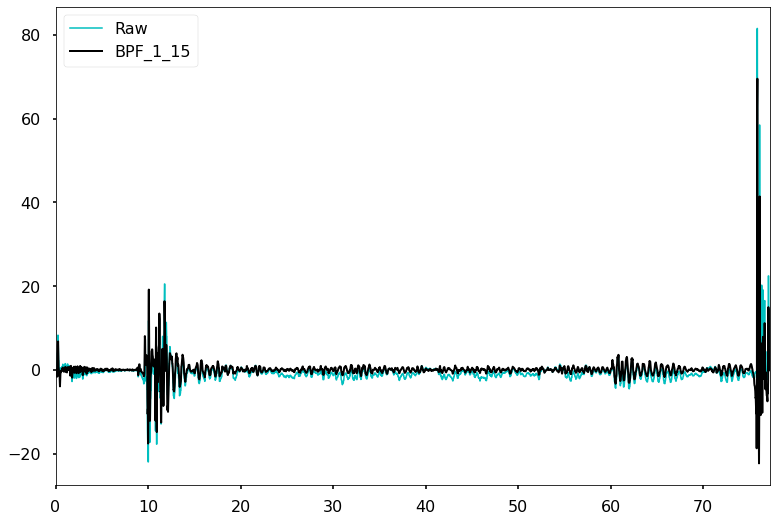

In [11]:
## Plots

bw_1_15 = bandPassFilter(az_vn, fs=40, low_freq=1, high_freq=15)

plt.plot(t,az_vn,color='c',LineWidth=1.5,label='Raw')
plt.plot(t,bw_1_15,color='k',LineWidth=2,label=f'BPF_1_15')
plt.xlim(t[0],t[-1])
plt.legend()
plt.show()

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


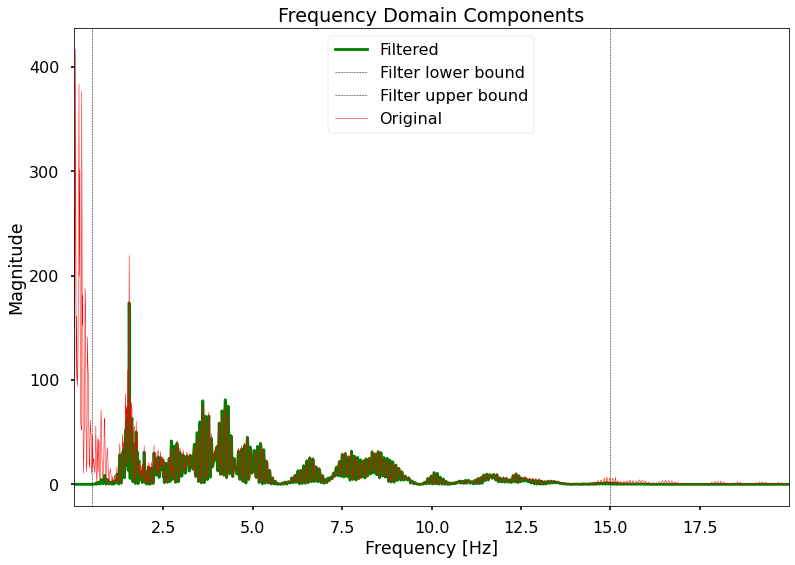

In [12]:
# Check the frequnecy components of the BPF signal:
plot_freq_dom(tdata, bw_1_15, 0.5, 15, original=az_vn)

In [13]:
# Pressure Derived
P = df['Pres']
v_NASA_pres = np.vectorize(hf.nasa_pres)
altitude_NASA_pres = v_NASA_pres(P, P0=99.035, T0=288.1)*ft
#T0 really was 303.3966... this would've been biased by the RPi tho

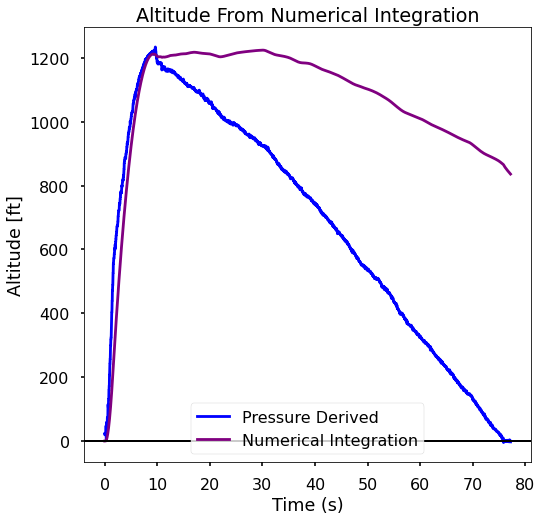

In [14]:
# Vanilla Numerical Integration
ax_vn = df['LinearAccelNed X'] * ft
ay_vn = df['LinearAccelNed Y'] * ft
az_vn = df['LinearAccelNed Z'] * -ft

accel_xyz = [ax_vn, ay_vn, az_vn]
v_vec, x_vec = hf.numerical_int(accel_xyz, tdata)

vx_vn, vy_vn, vz_vn = v_vec[0], v_vec[1], v_vec[2]
x_vn, y_vn, z_vn = x_vec[0], x_vec[1], x_vec[2]

fig1 = plt.figure(1, figsize=(8,8))
# Just the Displacement:
ax = plt.subplot(111)
l1 = ax.plot(tdata, altitude_NASA_pres, color='blue', label='Pressure Derived')
l4 = ax.plot(tdata, z_vn, color='purple', label='Numerical Integration')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Altitude From Numerical Integration")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Altitude [ft]")
ax.legend()
plt.show()

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


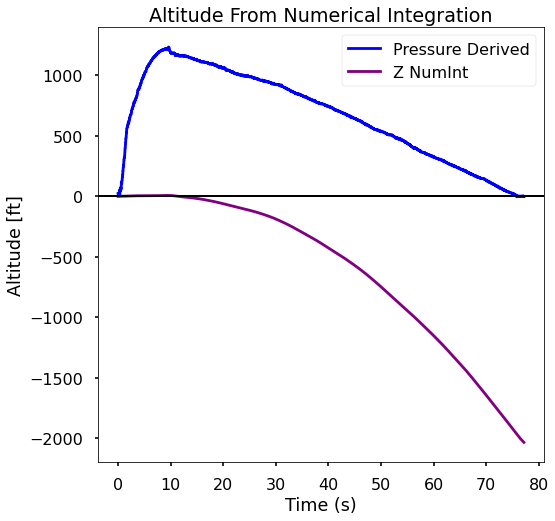

In [15]:
# SB Filtered Numerical Integration
accel_xyz = [ax_vn, ay_vn, ffilt]
v_vec, x_vec = hf.numerical_int(accel_xyz, tdata)

vx_vn, vy_vn, vz_vn = v_vec[0], v_vec[1], v_vec[2]
x_vn, y_vn, z_vn = x_vec[0], x_vec[1], x_vec[2]

fig1 = plt.figure(1, figsize=(8,8))
# Just the Displacement:
ax = plt.subplot(111)
l1 = ax.plot(tdata, altitude_NASA_pres, color='blue', label='Pressure Derived')
l4 = ax.plot(tdata, z_vn, color='purple', label='Z NumInt')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Altitude From Numerical Integration")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Altitude [ft]")
ax.legend()
plt.show()

In [16]:
def plot_displacement(tdata, accel_xyz, bool_3D=False):
    v_vec, x_vec = hf.numerical_int(accel_xyz, tdata)
    
    vx_vn, vy_vn, vz_vn = v_vec[0], v_vec[1], v_vec[2]
    x_vn, y_vn, z_vn = x_vec[0], x_vec[1], x_vec[2]

    fig1 = plt.figure(1, figsize=(8,8))
    # Just the Displacement:
    ax = plt.subplot(111)
    l1 = ax.plot(tdata, altitude_NASA_pres, color='c', label='Pressure Derived')
    l4 = ax.plot(tdata, z_vn, color='b', label='Z NumInt')
    l5 = plt.axhline(y=0, color='black', linewidth=2)
    if bool_3D is True:
        l4 = ax.plot(tdata, x_vn, color='r', label='X NumInt')
        l4 = ax.plot(tdata, y_vn, color='g', label='Y NumInt')
        ax.set_title("Displacement From Numerical Integration")
        ax.set_xlabel('Time (s)')
        ax.set_ylabel("Displacement [ft]")
    else:
        ax.set_title("Altitude From Numerical Integration")
        ax.set_xlabel('Time (s)')
        ax.set_ylabel("Altitude [ft]")
    ax.legend()
    plt.show()

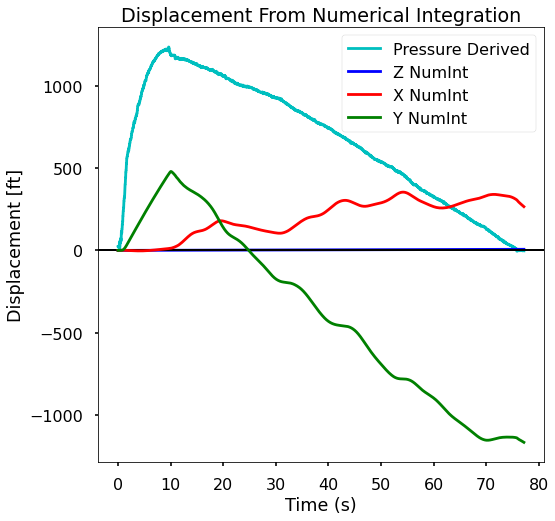

In [17]:
# Sciy Filtered Numerical Integration
accel_xyz = [ax_vn, ay_vn, bw_1_15]

plot_displacement(tdata, accel_xyz, bool_3D=True)